## 特征工程案例
- Kaggle 上有这样一个比赛：[城市自行车共享系统使用状况](https://www.kaggle.com/c/bike-sharing-demand)
- 数据提供两年每小时的租赁情况。训练集由每月前19天组成，测试集为每月的20日至月末。
- 参赛者需预测在测试集中每个小时租赁的自行车总数。
### 各变量意义
- datetime: 时间
- season：季节
- holiday：节假日
- workingday：工作日
- weather：天气 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain +Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp：温度
- atemp：体感温度
- humidity：湿度
- windspeed:风速
- casual：未注册用户租车数
- registered：已注册用户租车数
- count：租车总数

In [246]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [247]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [248]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


### 合并训练集和测试集

In [249]:
tt = train.append(test)
tt = tt.reset_index().drop('index', axis=1)
tt.head()

/home/f/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


### 训练集分析

/home/f/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


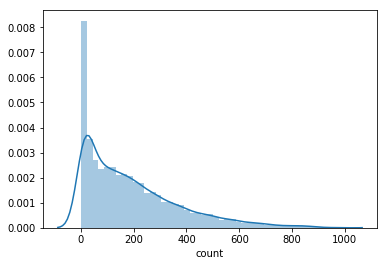

In [250]:
sns.distplot(train['count'])

In [251]:
# 时间处理
# 增加两列，分别为日期和小时
temp = pd.DatetimeIndex(train['datetime'])
train['year'] = temp.year
train['date'] = temp.date
train['hour'] = temp.hour
# 产生一个星期几的类别变量
train['dayofweek'] = pd.DatetimeIndex(train.date).dayofweek

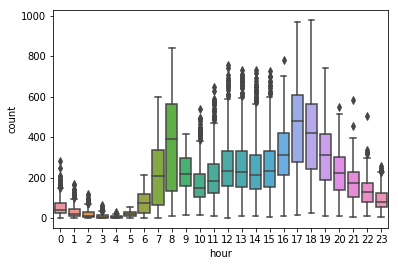

In [252]:
# 一天中各时间段对count的影响
sns.boxplot(train['hour'], train['count'])

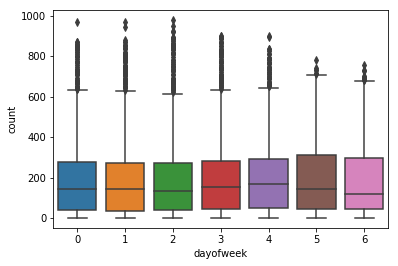

In [253]:
# 一周总各天对count的影响
sns.boxplot(train['dayofweek'], train['count'])

### 效果不明显，换个展现方式

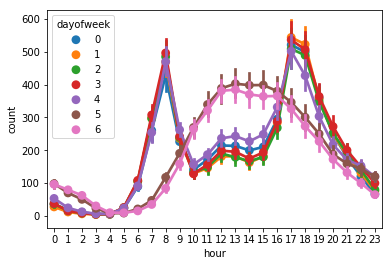

In [254]:
# 一周中每天的count变化情况
sns.pointplot(x='hour', y='count', hue='dayofweek', data=train)

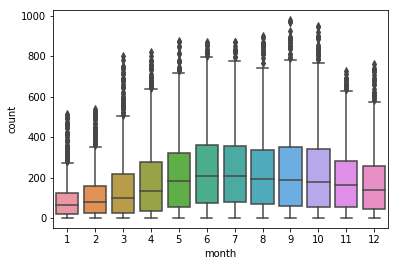

In [255]:
# 不同月份对count的影响
train['month'] = pd.to_datetime(train['datetime']).dt.month
sns.boxplot(train['month'], train['count'])

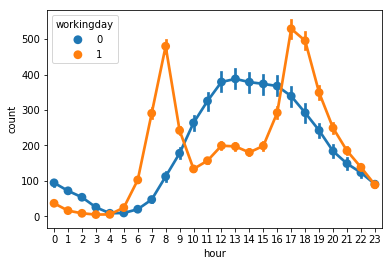

In [256]:
# 节假日对count的影响
sns.pointplot(x='hour', y='count',hue='workingday', data=train)

可以看出workingday与count的关系非常像dayofweek与count的关系，二者可以删掉一个

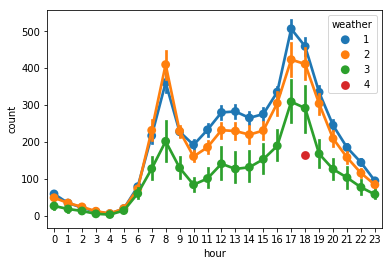

In [38]:
# 天气对count的影响
sns.pointplot(x='hour', y='count', hue='weather', data=train)

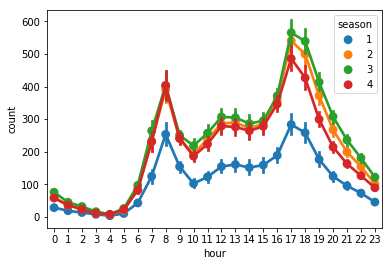

In [39]:
# 季节对count的影响
sns.pointplot(x='hour', y='count', hue='season', data=train)

### 对于离散性变量

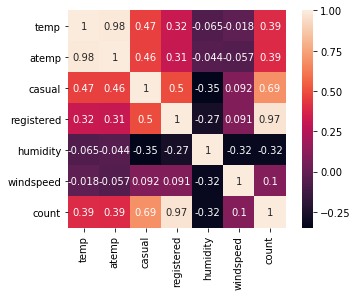

In [43]:
# 皮尔逊系数
cor=train[['temp', 'atemp', 'casual', 'registered', 'humidity','windspeed', 'count']].corr()
sns.heatmap(cor, square=True, annot=True)

### 从以上得出：
- temp和atemp变量高度线性相关，建模时取其一;
- casual和registered的总和就是count，删除即可
- humidity和windspeed变量和count相关性不高，直接删除
+ 所以，确定建模的变量有 hour, year, workingday, holiday, season, weather, atemp, count

### 对合并数据做特征处理

In [257]:
temp = pd.DatetimeIndex(tt['datetime'])
tt['year'] = temp.year
tt['hour'] = temp.hour
tt = tt[['hour', 'year', 'workingday', 'holiday', 'season', 'weather', 'atemp', 'count']]
# 对离散型变量做One-hot编码, 比如颜色红,黄, 蓝编码为[ [1,0,0], [0,1,0], [0,0,1] ]
tt = pd.get_dummies(tt, columns=['hour'], prefix=['hour'], drop_first=True)
tt = pd.get_dummies(tt, columns=['year'], prefix=['year'], drop_first=True)
tt = pd.get_dummies(tt, columns=['season'], prefix=['season'], drop_first=True)
tt = pd.get_dummies(tt, columns=['weather'], prefix=['weather'], drop_first=True)
tt.head()

,workingday,holiday,atemp,count,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_21,hour_22,hour_23,year_2012,season_2,season_3,season_4,weather_2,weather_3,weather_4
0,0,0,14.395,16.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,13.635,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,13.635,32.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,14.395,13.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,14.395,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 建模预测

In [259]:
# 从处理过后的数据集中提取训练集和测试集，[0:10886]和[10886:]
new_train = tt.iloc[:10886, :]
# 对count+1,然后取对数
y = np.log1p(new_train['count'])
new_test = tt.iloc[10886:, :].drop('count',axis=1)
new_train.drop('count', axis=1, inplace=True)
x = new_train
x.head()

/home/f/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,workingday,holiday,atemp,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,hour_21,hour_22,hour_23,year_2012,season_2,season_3,season_4,weather_2,weather_3,weather_4
0,0,0,14.395,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,13.635,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,13.635,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,14.395,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,14.395,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [236]:
y

0        2.833213
1        3.713572
2        3.496508
3        2.639057
4        0.693147
5        0.693147
6        1.098612
7        1.386294
8        2.197225
9        2.708050
10       3.610918
11       4.043051
12       4.442651
13       4.553877
14       4.672829
15       4.709530
16       4.543295
17       4.219508
18       3.583519
19       3.637586
20       3.610918
21       3.555348
22       3.367296
23       3.688879
24       2.890372
25       2.890372
26       2.302585
27       1.945910
28       1.386294
29       1.098612
           ...   
10856    6.265301
10857    5.869297
10858    5.594711
10859    5.129899
10860    4.890349
10861    4.406719
10862    3.737670
10863    2.772589
10864    1.386294
10865    1.791759
10866    2.079442
10867    3.465736
10868    4.727388
10869    5.897154
10870    6.520621
10871    5.762051
10872    5.105945
10873    5.303305
10874    5.468060
10875    5.365976
10876    5.389072
10877    5.472271
10878    5.814131
10879    6.333280
10880    6

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

### 尝试多元线性回归

In [238]:
from sklearn.linear_model import LinearRegression
lmodel = LinearRegression()
lmodel.fit(x, y)
cross_val_score(lmodel, x, y, cv=5).mean()  

0.8540144165763579

In [112]:
lmodel.fit(x_train, y_train)
pre = lmodel.predict(x_test)
mean_squared_error(y_test, pre)

0.2267929774010248

### 尝试随机森林

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(random_state=50, max_features='sqrt', oob_score=True)

In [116]:
# 调参 这一步计算量好大
para = {'n_estimators': np.arange(200, 241, 1)}
rf = GridSearchCV(estimator=rfr, param_grid=para, cv=5)
rf.fit(x, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [117]:
rf.best_params_

{'n_estimators': 222}

In [195]:
rfr = RandomForestRegressor(n_estimators=222, random_state=50, max_features='sqrt',oob_score=True)
cross_val_score(rfr, x, y, cv=5).mean()

0.9873139416135428

In [194]:
rfr.fit(x_train, y_train)
pre = rfr.predict(x_test)
mean_squared_error(y_test, pre)

0.008629833667255199

从结果来看随机森林优于多元线性回归

In [267]:
rfr.fit(x,y)

/home/f/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=True, random_state=50, verbose=0, warm_start=False)

In [262]:
co = rfr.predict(new_test)
m = []
# 对结果做指数减一，取四舍五入
for i in (np.exp(co) - 1):
    n = round(i)  
    m.append(n)
predict = pd.DataFrame({'datetime': test['datetime'], 'count': m})
predict.to_csv('rfr.csv', index=False)